In [ ]:
# import the image net data set 
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-11-16 15:27:57--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  16.3MB/s    in 18s     

2022-11-16 15:28:15 (13.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
# Unzipping of our data set & Delete the Zip File

!unzip /content/tiny-imagenet-200.zip
!rm /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 23 kB/s 
     |████████████████████████████████| 1.3 MB 30.6 MB/s 
     |████████████████████████████████| 463 kB 51.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


In [ ]:
### Imports ###
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

In [ ]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SHAPE = (64, 64)

In [ ]:
# Dataset creation
# The Dataset we used is Tiny ImageNet Visual Recognition Challenge.
# Our training set is made of a random subset of images from all 200 classes.

def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3)

Number of training examples = 2000
Number of test examples = 500
X_train shape: (2000, 64, 64, 3)


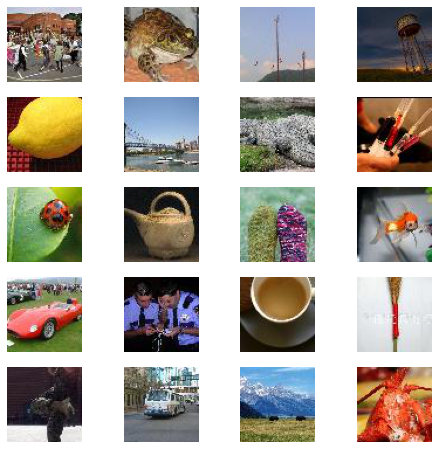

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.
# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]
# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

## Description
#### The model is composed of three parts: The Preparation Network, Hiding Network (Encoder) and the Reveal Network.
#### The goal is to be able to encode information about the secret image S into the cover image C, generating C' that closely resembles C, while still being able to decode information from C' to generate the decoded secret image S', which should resemble S as closely as possible.
#### The Preparation Network has the responsibility of preparing data from the secret image to be concatenated with the cover image and fed to the Hiding Network. The Hiding Network than transforms that input into the encoded cover image C'. Finally, the Reveal Network decodes the secret image S' from C'.
#### For stability, we add noise before the Reveal Network(reference through some paper). Although the author of the paper didn't originally specify the architecture of the three networks.
#### For both the Hiding and Reveal networks, we use 5 layers of 65 filters (50 3x3 filters, 10 4x4 filters and 5 5x5 filters). For the preparation network, we use only 2 layers with the same structure.

In [ ]:
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss

In [ ]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.

def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

In [ ]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

In [ ]:
# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
def train(e, lr = 0.001):
    
  NB_EPOCHS = e
  BATCH_SIZE = 32
  


  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  
  K.set_value(autoencoder_model.optimizer.lr,lr)
  K.set_value(reveal_model.optimizer.lr,lr)
  m = input_S.shape[0]
  loss_history = []

  for epoch in range(NB_EPOCHS):

      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)

      ae_loss = []
      rev_loss = []

      i = 0

      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          
          C_prime = encoder_model.predict([batch_S, batch_C])
          aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                    y=np.concatenate((batch_S, batch_C),axis=3))
          
          ae_loss.append(aeLoss)

          revLoss = reveal_model.train_on_batch(x=C_prime, y=batch_S)
          rev_loss.append(revLoss)
          
          
          i = idx
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | lr {}'.format(epoch + 1, i, m, np.mean(ae_loss), np.mean(rev_loss), lr ))
          

      lr = lr_schedule(epoch + 1)
      mean_ae_loss = np.mean(ae_loss)
      loss_history.append(mean_ae_loss)

  autoencoder_model.save_weights('./model_weights.hdf5')
  autoencoder_model.save("model.h5")
  return loss_history, autoencoder_model

In [ ]:
loss_history, autoencoder_model = train(20) # train funtion takes number of epochs as a input as i have traied my model for 1000 epochs i have saved 

Epoch 1 | Batch: 992 of 1000. Loss AE   78924.80 | Loss Rev   34685.96 | lr 0.001: 100%|██████████| 32/32 [00:30<00:00,  1.05it/s]
Epoch 2 | Batch: 992 of 1000. Loss AE   23691.25 | Loss Rev   13415.04 | lr 0.001: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
Epoch 3 | Batch: 992 of 1000. Loss AE   18112.81 | Loss Rev   10380.69 | lr 0.001: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
Epoch 4 | Batch: 992 of 1000. Loss AE   15279.20 | Loss Rev    8973.46 | lr 0.001: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
Epoch 5 | Batch: 992 of 1000. Loss AE   15384.48 | Loss Rev    9602.26 | lr 0.001: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
Epoch 6 | Batch: 992 of 1000. Loss AE   12273.50 | Loss Rev    8205.43 | lr 0.001: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
Epoch 7 | Batch: 992 of 1000. Loss AE   12079.09 | Loss Rev    8517.82 | lr 0.001: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
Epoch 8 | Batch: 992 of 1000. Loss AE   14114.67 | Loss Rev    9253.57 | lr 0.001: 

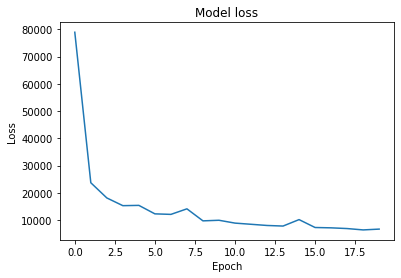

In [ ]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
# Load model

autoencoder_model.load_weights('/content/model_weights.hdf5')

In [ ]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 28.122784
C error per pixel [0, 255]: 19.494253


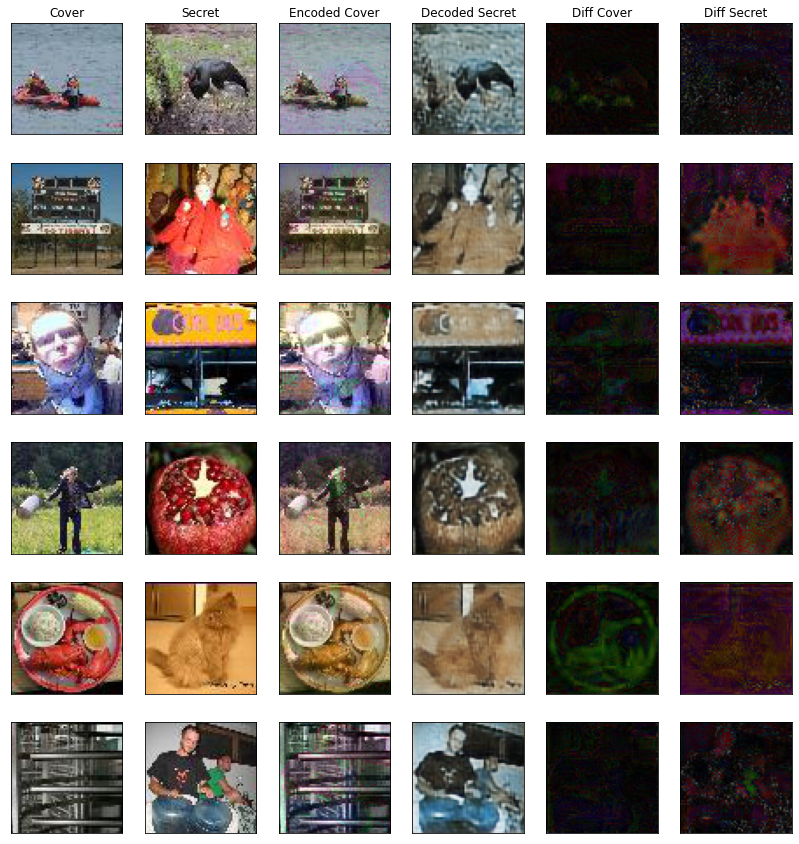

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

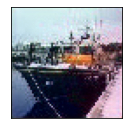

In [ ]:
plt.figure(figsize=(14, 15))
show_image(decoded_C[5], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

In [ ]:
# Python program implementing Image Steganography

# PIL module is used to extract
# pixels of image and modify it
from PIL import Image

# Convert encoding data into 8-bit binary
# form using ASCII value of characters
def genData(data):

		# list of binary codes
		# of given data
		newd = []

		for i in data:
			newd.append(format(ord(i), '08b'))
		return newd

# Pixels are modified according to the
# 8-bit binary data and finally returned
def modPix(pix, data):

	datalist = genData(data)
	lendata = len(datalist)
	imdata = iter(pix)

	for i in range(lendata):

		# Extracting 3 pixels at a time
		pix = [value for value in imdata.__next__()[:3] +
								imdata.__next__()[:3] +
								imdata.__next__()[:3]]

		# Pixel value should be made
		# odd for 1 and even for 0
		for j in range(0, 8):
			if (datalist[i][j] == '0' and pix[j]% 2 != 0):
				pix[j] -= 1

			elif (datalist[i][j] == '1' and pix[j] % 2 == 0):
				if(pix[j] != 0):
					pix[j] -= 1
				else:
					pix[j] += 1
				# pix[j] -= 1

		# Eighth pixel of every set tells
		# whether to stop ot read further.
		# 0 means keep reading; 1 means thec
		# message is over.
		if (i == lendata - 1):
			if (pix[-1] % 2 == 0):
				if(pix[-1] != 0):
					pix[-1] -= 1
				else:
					pix[-1] += 1

		else:
			if (pix[-1] % 2 != 0):
				pix[-1] -= 1

		pix = tuple(pix)
		yield pix[0:3]
		yield pix[3:6]
		yield pix[6:9]

def encode_enc(newimg, data):
	w = newimg.size[0]
	(x, y) = (0, 0)

	for pixel in modPix(newimg.getdata(), data):

		# Putting modified pixels in the new image
		newimg.putpixel((x, y), pixel)
		if (x == w - 1):
			x = 0
			y += 1
		else:
			x += 1

# Encode data into image
def encode():
	img = input("Enter image name(with extension) : ")
	image = Image.open(img, 'r')

	data = input("Enter data to be encoded : ")
	if (len(data) == 0):
		raise ValueError('Data is empty')

	newimg = image.copy()
	encode_enc(newimg, data)

	new_img_name = input("Enter the name of new image(with extension) : ")
	newimg.save(new_img_name, str(new_img_name.split(".")[1].upper()))

# Decode the data in the image
def decode():
	img = input("Enter image name(with extension) : ")
	image = Image.open(img, 'r')

	data = ''
	imgdata = iter(image.getdata())

	while (True):
		pixels = [value for value in imgdata.__next__()[:3] +
								imgdata.__next__()[:3] +
								imgdata.__next__()[:3]]

		# string of binary data
		binstr = ''

		for i in pixels[:8]:
			if (i % 2 == 0):
				binstr += '0'
			else:
				binstr += '1'

		data += chr(int(binstr, 2))
		if (pixels[-1] % 2 != 0):
			return data

# Main Function
def main():
	a = int(input(":: Welcome to Steganography ::\n"
						"1. Encode\n2. Decode\n"))
	if (a == 1):
		encode()

	elif (a == 2):
		print("Decoded Word : " + decode())
	else:
		raise Exception("Enter correct input")

# Driver Code
if __name__ == '__main__' :

	# Calling main function
	main()


:: Welcome to Steganography ::
1. Encode
2. Decode
1
Enter image name(with extension) : dragon.jpeg
Enter data to be encoded : isa
Enter the name of new image(with extension) : susnormal.jpeg
